---

"COVID-19 Open Research Data Analysis"
---

This is an analysis report of the Novel Coronavirus (COVID-19)
Aim for data processing, visualisation and statstics.
Data provided by Johns Hopkins University [github](https://github.com/CSSEGISandData/COVID-19)

Try executing this chunk by clicking the *Run* button within the chunk or by placing your cursor inside it and pressing *Ctrl+Shift+Enter*. 

In [1]:
# Source code: http://yanchang.rdatamining.com/

# R Packages:
library(magrittr) # pipline operations
library(lubridate) # date operation
library(tidyverse) # data science pips
library(gridExtra) # grid based plots
library(kableExtra) # build HTML and LaTeX tables
library(dplyr)

Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.4
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
Warning message:
"package 'tibble' was built under R version 3.6.2"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x lubridate::as.difftime() masks base::as.difftime()
x lubridate::date()        masks base::date()
x tidyr::extract()        

In [2]:
# Loading data
# At first, three CSV files, are downloaded and saved as local files
# and then loaded into R

# source data files
filenames <- c('time_series_19-covid-Confirmed.csv',
               'time_series_19-covid-Deaths.csv', 
               'time_series_19-covid-Recovered.csv')
url.path <- paste0('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/',
                   'master/csse_covid_19_data/csse_covid_19_time_series/')

#download files to local folder
download <- function(filename) {
  url <- file.path(url.path, filename)
  dest <- file.path('./data', filename)
  download.file(url, dest)
}
bin <- lapply(filenames, download)


# load data into R
data.confirmed <- read.csv('./data/time_series_19-covid-Confirmed.csv')
data.deaths <- read.csv('./data/time_series_19-covid-Deaths.csv')
data.recovered <- read.csv('./data/time_series_19-covid-Recovered.csv')

# check dimension of data confirmed
dim(data.confirmed)

[1] 460  60

In [3]:
# check time frame of the data
n.col <- ncol(data.confirmed) # 58 variables
# get dates from column names
dates <- names(data.confirmed)[5:n.col] %>% substr(2,8) %>% mdy()
range(dates)

min.date <- min(dates)
max.date <- max(dates)
# last update on 16 March 2020 max.date

# Data Preparation steps:
# 1.From wide to long format
# 2.Aggregate by country
# 3. merge into a signe dataset
# cleaning and transformation
cleanData <- function(data) {
  ## remove some columns
  data %<>% select(-c(Province.State, Lat, Long)) %>% rename(country=Country.Region) 
  ## convert from wide to long format
  data %<>% gather(key=date, value=count, -country) 
  ## convert from character to date 
  data %<>% mutate(date = date %>% substr(2,8) %>% mdy()) 
  ## aggregate by country 
  data %<>% group_by(country, date) %>% summarise(count=sum(count)) %>% as.data.frame()
  return(data)
}
# clean the three datasets
data.confirmed %<>% cleanData() %>% rename(confirmed=count)  
data.deaths %<>% cleanData() %>% rename(deaths=count)
data.recovered %<>% cleanData() %>% rename(recovered=count)

# merge above 3 datasets into one, by country and date
data <- data.confirmed %>% merge(data.deaths) %>% merge(data.recovered)

# countries/regions with confirmed cases (excl cruise ships)
countries <- data %>% pull(country) %>% setdiff('Cruise Ship')


[1] "2020-01-22" "2020-03-17"

In [4]:

# first 10 records when it first broke out in China
# Last 10 records when it first broke out in Spain
data %>% filter(country =='Spain')%>% tail(10)


,country,date,confirmed,deaths,recovered
47,Spain,2020-03-08,673,17,30
48,Spain,2020-03-09,1073,28,32
49,Spain,2020-03-10,1695,35,32
50,Spain,2020-03-11,2277,54,183
51,Spain,2020-03-12,2277,55,183
52,Spain,2020-03-13,5232,133,193
53,Spain,2020-03-14,6391,195,517
54,Spain,2020-03-15,7798,289,517
55,Spain,2020-03-16,9942,342,530
56,Spain,2020-03-17,11748,533,1028


In [5]:

## Cases for the Whole World
# counts for worldwide
data.world <- data %>% group_by(date) %>%
  summarise(country='World',
            confirmed=sum(confirmed),
            deaths=sum(deaths),
            recovered=sum(recovered))

data %<>% rbind(data.world)

# remaining confirmed cases
data %<>% mutate(remaining.confirmed = confirmed - deaths - recovered)

In [6]:
# Daily Increases and Death Rates

# rate.upper = total deaths and recovered cases
# rate.lower = total deaths and confirmed cases
# expected death rate is to be between above rates
# rate.daily =daily deaths and recovered cases

## sort by country and date
data %<>% arrange(country,date)
# daily increases of deaths and recovered cases
# set NA to increase on day1
n <- nrow(data)
day1 <- min(data$date) # set NA day1
data %<>% mutate(confirmed.inc=ifelse(date ==day1,NA, confirmed - lag(confirmed, n=1)),
                 deaths.inc=ifelse(date ==day1,NA,deaths - lag(deaths, n=1)),
                 recovered.inc=ifelse(date ==day1,NA,recovered - lag(recovered, n=1)))

# death rate base on total deaths and recovered cases
data %<>% mutate(rate.upper = (100 *deaths / (deaths + recovered)) %>% round(1))
# lower bound: death rate based on total confirmed cases
data %<>% mutate(rate.lower = (100 * deaths / confirmed) %>% round(1))
# death rate based on number f death/recovered on every single day
data %<>% mutate(rate.daily = (100 * deaths.inc / (deaths.inc + recovered.inc)) %>% round(1))

In [7]:
# Visualisation
# After preparing the data, we portrait it in various graphs

# TOP Ten Countries
# ranking by confirmed cases
data.latest <- data %>% filter(date ==max(date)) %>%
                                select(country, date, confirmed, deaths, recovered, remaining.confirmed) %>%
                                mutate(ranking = dense_rank(desc(confirmed)))
# top 10 countries incl 11 World
top.countries <- data.latest %>% filter(ranking <= 11) %>%
  arrange(ranking) %>% pull(country) %>% as.character()
top.countries %>% setdiff('World') %>% print()

## add 'Others'
top.countries %<>% c('Others')
## put all others in a single group of 'Others'
df <- data.latest %>% filter(!is.na(country) & country!= 'World')%>%
  mutate(country=ifelse(ranking <= 11, as.character(country), 'Others')) %>%
  mutate(country=country %>% factor(levels = c(top.countries)))
df %<>% group_by(country) %>% summarise(confirmed=sum(confirmed))  

 [1] "China"          "Italy"          "Iran"           "Spain"         
 [5] "Germany"        "Korea, South"   "France"         "US"            
 [9] "Switzerland"    "United Kingdom"


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"

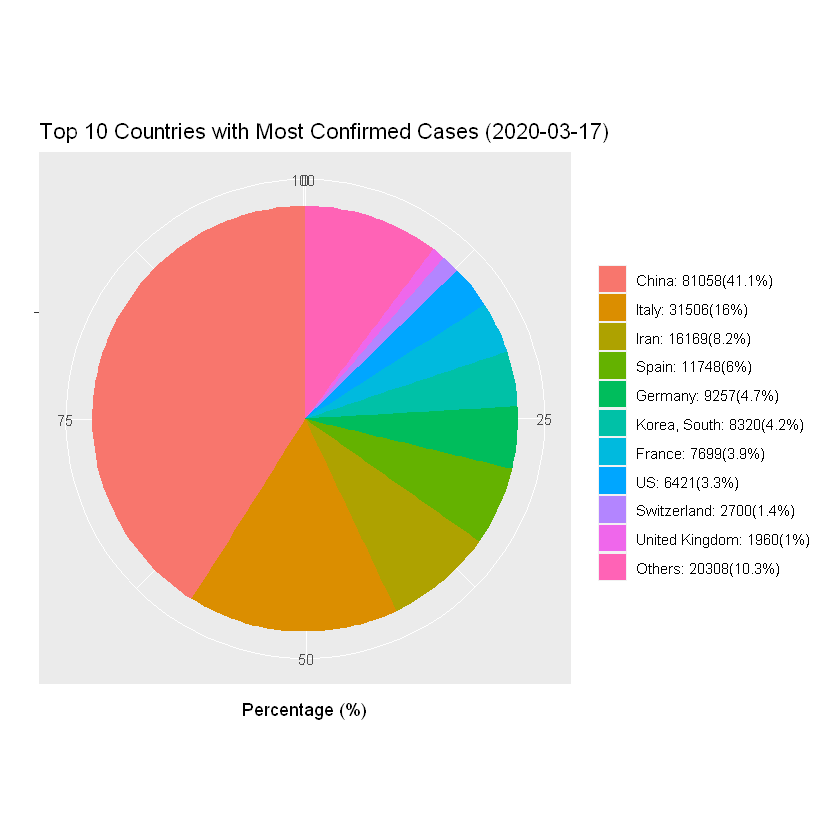

In [8]:
### TABLE
# percentage and label
df %<>% mutate(per = (100*confirmed/sum(confirmed)) %>% round(1)) %>%
                 mutate(txt = paste0(country, ': ', confirmed, '(', per, '%)'))
df %>% ggplot(aes(fill=country)) +
  geom_bar(aes(x ='', y = per), stat= 'identity') +
  coord_polar('y', start =0) +
  xlab('') + ylab('Percentage (%)') +
  labs(title=paste0('Top 10 Countries with Most Confirmed Cases (', max.date,')')) +
  scale_fill_discrete(name='Country', labels = df$txt) +
  theme(legend.title = element_blank(), legend.text = element_text((size=7)))
   

In [18]:
# Table
data.latest %>% filter(country %in% top.countries) %>% select(-c(date, ranking)) %>%
                                                                arrange(desc(confirmed))

country,confirmed,deaths,recovered,remaining.confirmed
World,197146,7905,80840,108401
China,81058,3230,68798,9030
Italy,31506,2503,2941,26062
Iran,16169,988,5389,9792
Spain,11748,533,1028,10187
Germany,9257,24,67,9166
"Korea, South",8320,81,1407,6832
France,7699,148,12,7539
US,6421,108,17,6296
Switzerland,2700,27,4,2669


Warning message:
"Transformation introduced infinite values in continuous y-axis"Warning message:
"Transformation introduced infinite values in continuous y-axis"

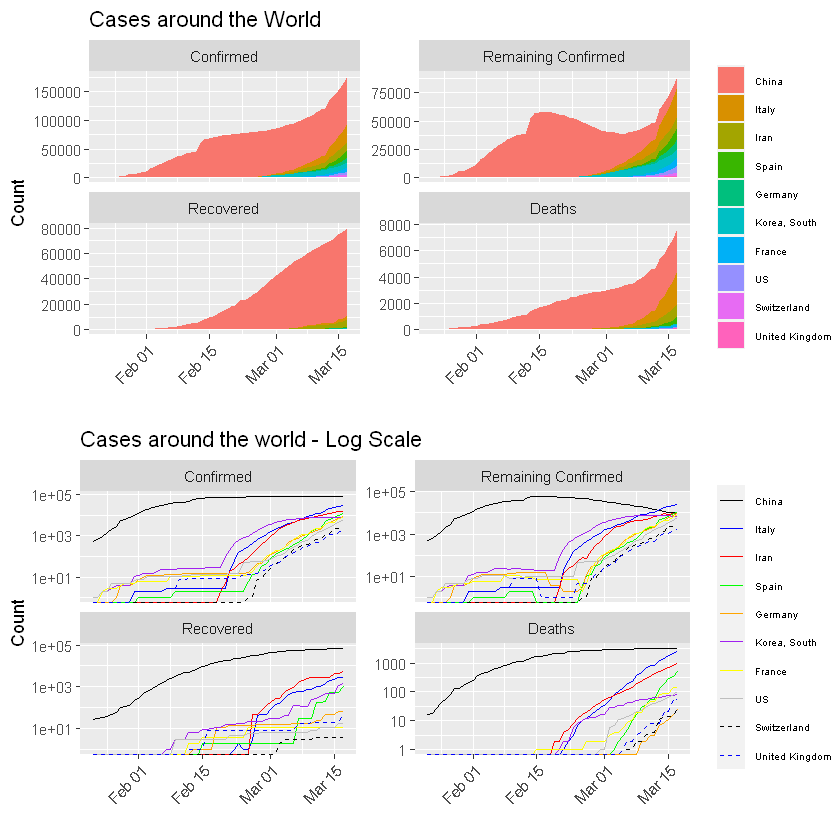

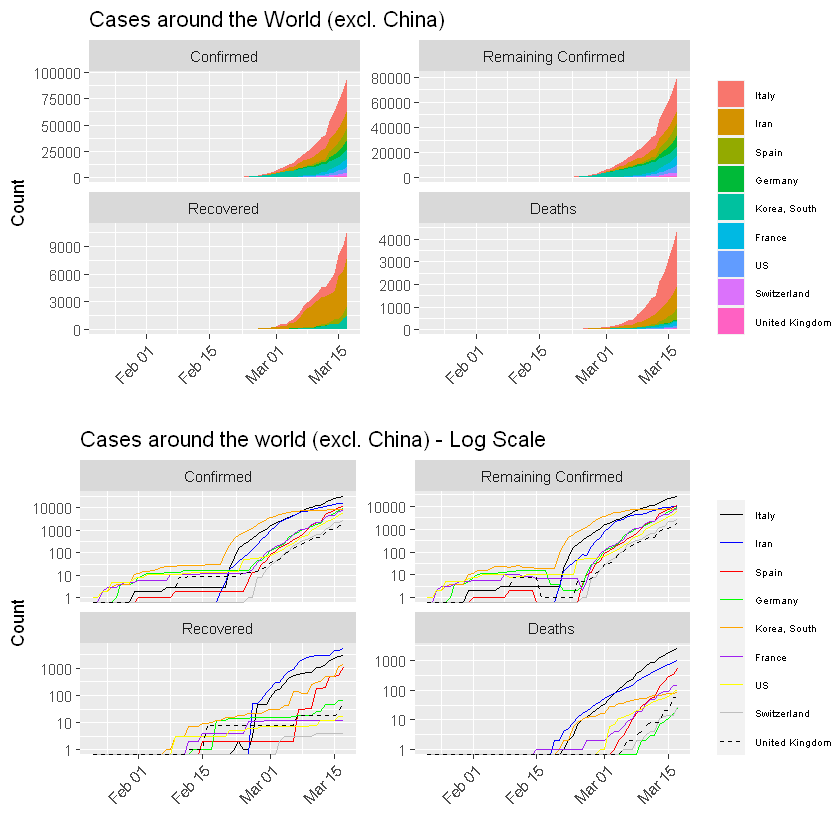

In [10]:
                                                        
 # Comparison across Countries
# convert from wide to long format, for drawing area plot
data.long <- data %>%
  select(c(country, date, confirmed, remaining.confirmed, recovered, deaths)) %>%
  gather(key = type, value = count, -c(country,date))
# set for factor levels to show them in a desirable order
data.long %<>% mutate(type =recode_factor(type, confirmed= 'Confirmed',
                                          remaining.confirmed = 'Remaining Confirmed',
                                          recovered= 'Recovered',
                                          deaths='Deaths'))
# plot cases by type
df <- data.long %>% filter(country %in% top.countries) %<>%
  mutate(country=country %>% factor(levels=c(top.countries)))


### CASES AROUND WORLD
p <- df%>% filter(country !='World') %>%
  ggplot(aes(x=date, y=count)) + xlab('') + ylab('Count') +
  theme(legend.title=element_blank(),
        legend.text = element_text(size=6),
        legend.key.size=unit(0.6, 'cm'),
        axis.text.x=element_text(angle = 45, hjust=1)) +
  facet_wrap(~type, ncol = 2, scale='free_y')
# area plot
plot1 <- p + geom_area(aes(fill=country)) +
  labs(title='Cases around the World')
# line plot and in log scale
linetypes <- rep(c('solid','dashed','dotted'), each=8)
colors <- rep(c('black','blue','red','green','orange', 'purple', 'yellow', 'grey'), 3)
plot2 <- p + geom_line(aes(color=country, linetype=country)) +
  scale_linetype_manual(values = linetypes) +
  scale_color_manual(values = colors) +
  labs(title = 'Cases around the world - Log Scale') +
  scale_y_continuous(trans = 'log10')
# shows two plots together
grid.arrange(plot1, plot2, ncol=1)

# Plot: excluding China
p <- df%>% filter(!(country %in% c('World', 'China'))) %>%
  ggplot(aes(x=date, y=count)) + xlab('') + ylab('Count') +
  theme(legend.title=element_blank(),
        legend.text = element_text(size=6),
        legend.key.size=unit(0.6, 'cm'),
        axis.text.x=element_text(angle = 45, hjust=1)) +
  facet_wrap(~type, ncol = 2, scale='free_y')
# area plot
plot1 <- p + geom_area(aes(fill=country)) +
  labs(title='Cases around the World (excl. China)')
# line plot and in log scale
linetypes <- rep(c('solid','dashed','dotted'), each=8)
colors <- rep(c('black','blue','red','green','orange', 'purple', 'yellow', 'grey'), 3)
plot2 <- p + geom_line(aes(color=country, linetype=country)) +
  scale_linetype_manual(values = linetypes) +
  scale_color_manual(values = colors) +
  labs(title = 'Cases around the world (excl. China) - Log Scale') +
  scale_y_continuous(trans = 'log10')
# shows two plots together
grid.arrange(plot1, plot2, ncol=1)

Warning message:
"Transformation introduced infinite values in continuous y-axis"

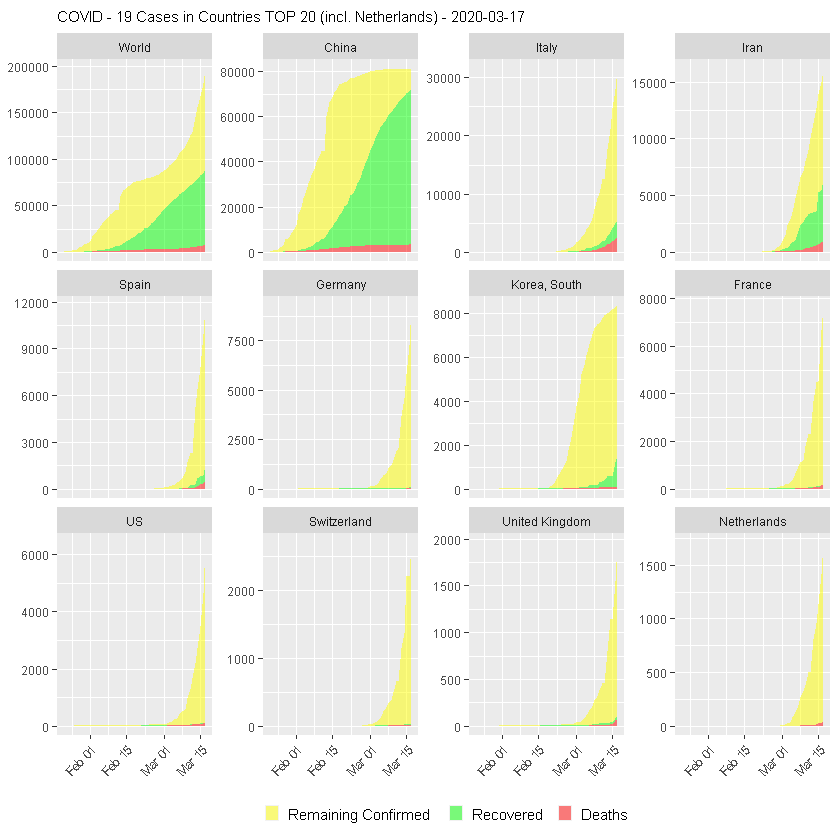

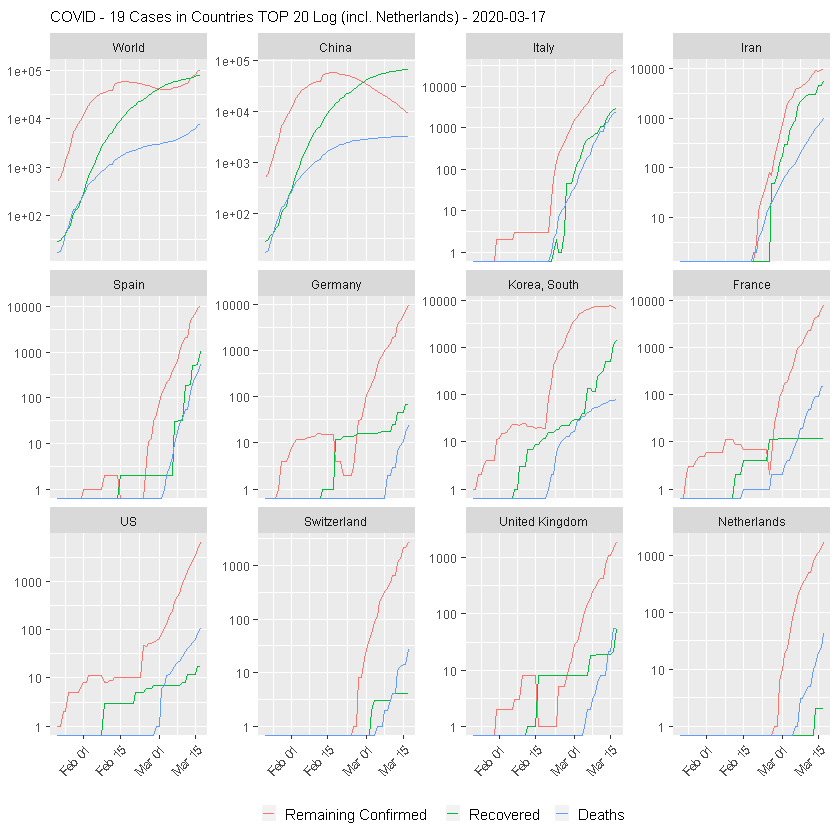

In [11]:

## If The Netherland is not top 20, add it in and remove 'Others'
if(!('Netherlands' %in% top.countries)) {
  top.countries %<>% setdiff('Others') %>% c('Netherlands')
  df <- data.long %>% filter(country %in% top.countries) %>%
    mutate(country=country %>% factor(levels = c(top.countries)))
}

# cases by country - area plot
df %>% filter(type != 'Confirmed') %>%
  ggplot(aes(x=date, y=count, fill=type)) +
  geom_area(alpha=0.5) +
  labs(title = paste0('COVID - 19 Cases in Countries TOP 20 (incl. Netherlands) - ', max.date)) +
  scale_fill_manual(values=c('yellow','green','red')) +
  theme(legend.title=element_blank(), legend.position='bottom',
        plot.title= element_text(size = 9),
        axis.title.x=element_blank(),
        axis.title.y = element_blank(),
        legend.key.size = unit(0.3, 'cm'),
        strip.text.x = element_text(size=7),
        axis.text=element_text(size = 7),
        axis.text.x = element_text(angle=45, hjust=1)) +
  facet_wrap(~country, ncol=4, scale='free_y') #+ scale_y_continuous(trans = 'log10')

# cases by country - log case
df %>% filter(type != 'Confirmed') %>%
  ggplot(aes(x=date, y=count, color=type)) +
  geom_line() +
  labs(title = paste0('COVID - 19 Cases in Countries TOP 20 Log (incl. Netherlands) - ', max.date)) +
  scale_fill_manual(values=c('red','green','blue')) +
  theme(legend.title=element_blank(), legend.position='bottom',
        plot.title= element_text(size = 9),
        axis.title.x=element_blank(),
        axis.title.y = element_blank(),
        legend.key.size = unit(0.3, 'cm'),
        strip.text.x = element_text(size=7),
        axis.text=element_text(size = 7),
        axis.text.x = element_text(angle=45, hjust=1)) +
  facet_wrap(~country, ncol=4, scale='free_y') + scale_y_continuous(trans = 'log10')

In [12]:

### Current confirmed cases:
#data.test <- data %>% filter(country %in% c('Italy', 'Spain', 'Netherlands'))
data %<>% filter(country== 'World')
n <- nrow(data)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

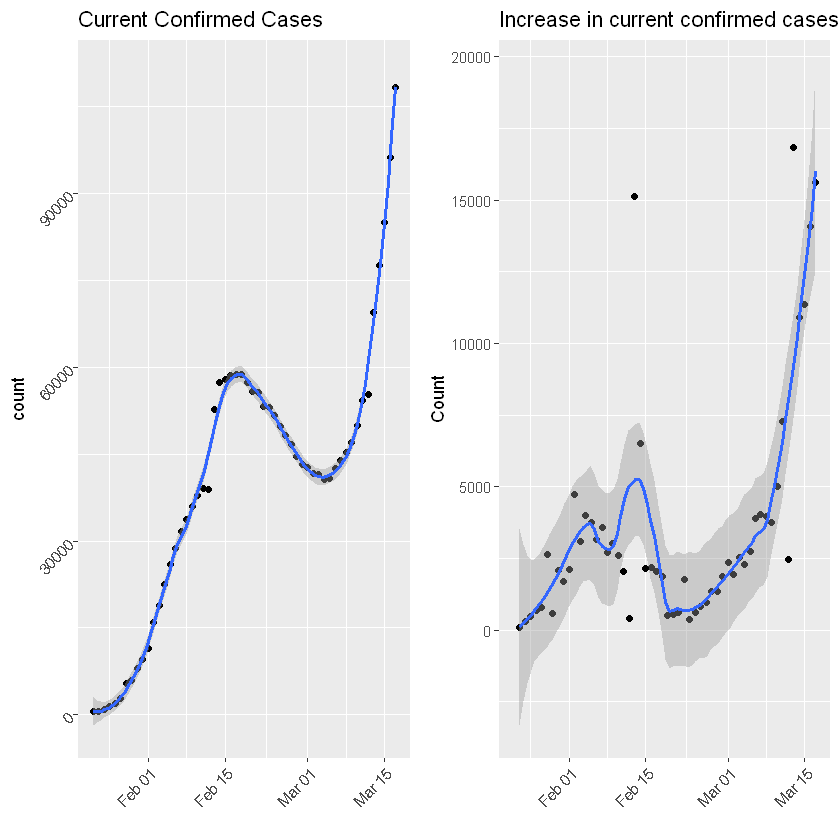

In [13]:

# current confirmed and it is increase with worldwide case
plot1 <- ggplot(data, aes(x = date, y=remaining.confirmed)) +
  geom_point() + geom_smooth(span=0.3) +
  xlab('') + ylab('count') + labs(title= 'Current Confirmed Cases') +
  theme(axis.text = element_text(angle = 45, hjust=1))
plot2 <- ggplot(data, aes(x =date, y=confirmed.inc)) +
  geom_point() + geom_smooth(span=0.3) +
  xlab('') + ylab('Count') + labs(title= 'Increase in current confirmed cases') +
  theme (axis.text.x = element_text(angle=45, hjust =1))
# show plot 1 and 2 side by side
grid.arrange(plot1, plot2, ncol=2)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

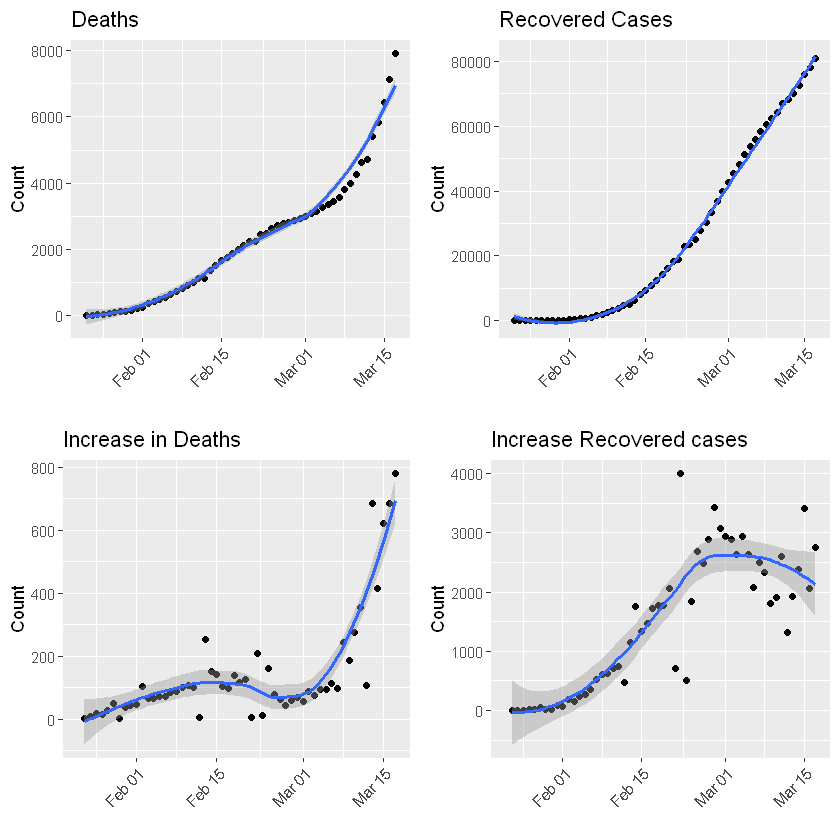

In [14]:
# Deaths and recovery cases
plot1 <- ggplot(data,aes(x=date, y=deaths)) +
  geom_point() + geom_smooth() +
  xlab('') + ylab('Count') + labs(title = 'Deaths') +
  theme(axis.text.x = element_text(angle = 45, hjust=1))
plot2 <- ggplot(data,aes(x=date, y=recovered)) +
  geom_point() + geom_smooth() +
  xlab('') + ylab('Count') + labs(title = 'Recovered Cases') +
  theme(axis.text.x = element_text(angle = 45, hjust=1))
plot3 <- ggplot(data,aes(x=date, y=deaths.inc)) +
  geom_point() + geom_smooth() +
  xlab('') + ylab('Count') + labs(title = 'Increase in Deaths') +
  theme(axis.text.x = element_text(angle = 45, hjust=1))
plot4 <- ggplot(data,aes(x=date, y=recovered.inc)) +
  geom_point() + geom_smooth() +
  xlab('') + ylab('Count') + labs(title = 'Increase Recovered cases') +
  theme(axis.text.x = element_text(angle = 45, hjust=1))
# shows plots together
grid.arrange(plot1, plot2, plot3, plot4, nrow=2)

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."

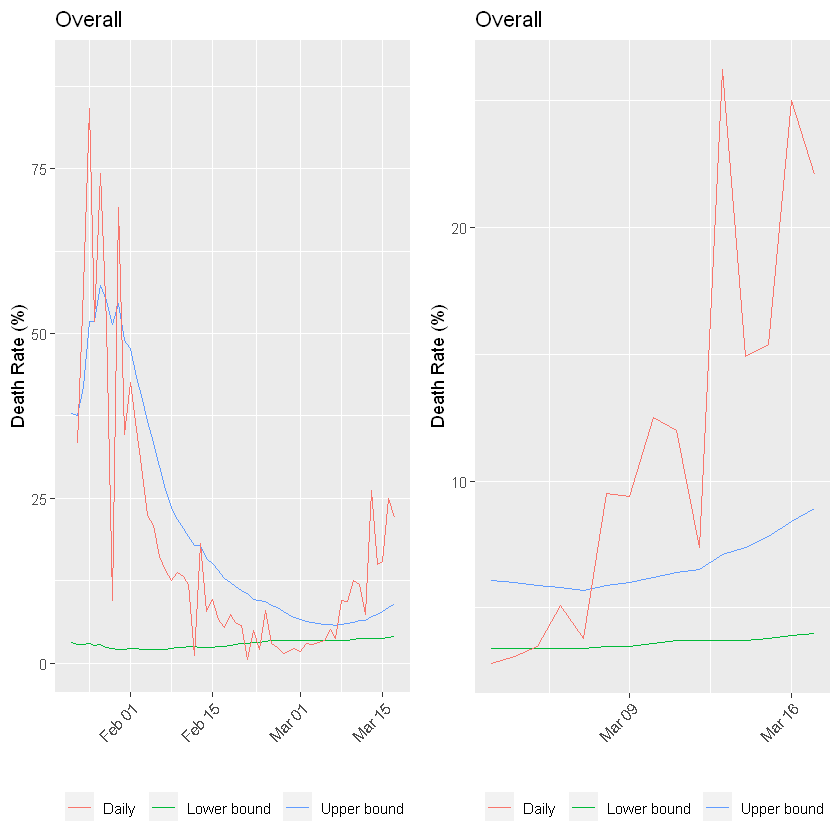

In [15]:

## Deaths rates
plot1 <- ggplot(data, aes(x=date)) +
  geom_line(aes(y=rate.upper, colour='Upper bound')) +
  geom_line(aes(y=rate.lower, colour='Lower bound')) +
  geom_line(aes(y=rate.daily, colour='Daily')) +
  xlab('') + ylab('Death Rate (%)') + labs(title='Overall') +
  theme(legend.position='bottom', legend.title=element_blank(),
        axis.text.x=element_text(angle=45, hjust=1)) +
  ylim(0,90)
## insert las two weeks
plot2 <- ggplot(data[n-(14:0),], aes(x=date)) +
  geom_line(aes(y=rate.upper, colour='Upper bound')) +
  geom_line(aes(y=rate.lower, colour='Lower bound')) +
  geom_line(aes(y =rate.daily, colour= 'Daily')) +
  xlab('') + ylab('Death Rate (%)') + labs(title = 'Overall') +
  theme(legend.position='bottom', legend.title =element_blank(),
        axis.text.x=element_text(angle=45, hjust=1))
grid.arrange(plot1, plot2, nrow=1)

In [17]:
# COVID-19 Cases Worldwide

datatable <- data %>% arrange(desc(date)) %>%
  select(c(date, confirmed, deaths, recovered, remaining.confirmed,
           confirmed.inc, deaths.inc, recovered.inc, rate.lower, rate.upper, rate.daily))


date,confirmed,deaths,recovered,remaining.confirmed,confirmed.inc,deaths.inc,recovered.inc,rate.lower,rate.upper,rate.daily
2020-03-17,197146,7905,80840,108401,15615,779,2752,4.0,8.9,22.1
2020-03-16,181531,7126,78088,96317,14082,686,2054,3.9,8.4,25.0
2020-03-15,167449,6440,76034,84975,11352,621,3410,3.8,7.8,15.4
2020-03-14,156097,5819,72624,77654,10904,415,2373,3.7,7.4,14.9
2020-03-13,145193,5404,70251,69538,16850,684,1927,3.7,7.1,26.2
2020-03-12,128343,4720,68324,55299,2478,105,1321,3.7,6.5,7.4
2020-03-11,125865,4615,67003,54247,7273,353,2599,3.7,6.4,12.0
2020-03-10,118592,4262,64404,49926,5031,274,1910,3.6,6.2,12.5
2020-03-09,113561,3988,62494,47079,3766,186,1800,3.5,6.0,9.4
2020-03-08,109795,3802,60694,45299,3974,244,2336,3.5,5.9,9.5


In [29]:
# Latest Cases by Country
data.latest %>% arrange(desc(confirmed)) %>% select(-c(date)) %>% head(15)

country,confirmed,deaths,recovered,remaining.confirmed,ranking
World,197146,7905,80840,108401,1
China,81058,3230,68798,9030,2
Italy,31506,2503,2941,26062,3
Iran,16169,988,5389,9792,4
Spain,11748,533,1028,10187,5
Germany,9257,24,67,9166,6
"Korea, South",8320,81,1407,6832,7
France,7699,148,12,7539,8
US,6421,108,17,6296,9
Switzerland,2700,27,4,2669,10
